<a href="https://colab.research.google.com/github/SidDsloth/Deep-Learning-Pytorch/blob/master/Deep-Learning-Pytorch/Neural_Style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import print_function

import torch
import torch.nn as nn #for nn
import torch.nn.functional as F
import torch.optim as optim #for GD

from PIL import Image # for load img
import matplotlib.pyplot as plt

import torchvision.transforms as transforms #transform PIL img to tensor
import torchvision.models as models #load pre-trained model

import copy # to deep copy
models

<module 'torchvision.models' from '/usr/local/lib/python3.6/dist-packages/torchvision/models/__init__.py'>

In [0]:
device=torch.device("cuda") # to run network on the GPU

In [0]:
imsize=512

loader=transforms.Compose([transforms.Resize(imsize),
                           transforms.ToTensor()])

def image_loader(image_name):
  image=Image.open(image_name)
  image=loader(image).unsqueeze(0)
  return image.to(device, torch.float)

style_img=image_loader("/content/Starry-Night.jpg")
content_img=image_loader("/content/nitk(2)(1).jpg")

assert style_img.size()==content_img.size()

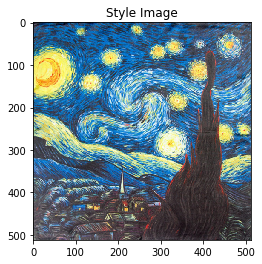

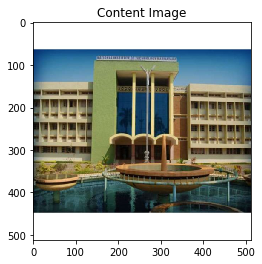

In [0]:
unloader=transforms.ToPILImage() #reconvert to PIL image
plt.ion()
def imshow(tensor, title=None):
  image=tensor.cpu().clone()
  image=image.squeeze(0)
  image=unloader(image)
  plt.imshow(image)
  if title is not None:
    plt.title(title)
  plt.pause(.001)
plt.figure()
imshow(style_img,title='Style Image')
plt.figure()
imshow(content_img,title='Content Image')

In [0]:
class ContentLoss(nn.Module):
  def __init__(self,target,):
    super(ContentLoss,self).__init__()
    self.target=target.detach()# Detach target from tree to dynamically compute gradien
  def forward(self,input):
    self.loss=F.mse_loss(input,self.target)
    return input
 

In [0]:
def gram_matrix(input):
  a,b,c,d=input.size() #a=batch_size,b=no of feature map, (c,d)=dim of map
  features=input.view(a*b,c*d) #creating the transposed matrix
  G=torch.mm(features,features.t()) #compute gram prod
  
  return G.div(a*b*c*d)

In [0]:
class StyleLoss(nn.Module):
  def __init__(self,target_feature):
    super(StyleLoss,self).__init__()
    self.target=gram_matrix(target_feature).detach()
  def forward(self,input):
    G=gram_matrix(input)
    self.loss=F.mse_loss(G,self.target)
    return input

In [0]:
cnn=models.vgg19(pretrained=True).features.to(device).eval()

In [0]:
cnn_normalization_mean=torch.tensor([0.485,0.456,0.406]).to(device)
cnn_normalization_std=torch.tensor([0.229,0.224,0.225]).to(device)

#module to normalize i/p image
class Normalization(nn.Module):
  def __init__(self,mean,std):
    super(Normalization,self).__init__()
    
    self.mean=torch.tensor(mean).view(-1,1,1)
    self.std=torch.tensor(std).view(-1,1,1)
    
  def forward(self,img):
    return (img-self.mean)/self.std

In [0]:
#desired depth of the layers being defined
content_layers_default=['conv_4']
style_layers_default=['conv_1','conv_2','conv_3','conv_4','conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std, style_img, content_img, content_layers=content_layers_default, style_layers=style_layers_default):
  cnn=copy.deepcopy(cnn)
  
  #normalization module
  normalization=Normalization(normalization_mean, normalization_std).to(device)
  
  content_losses=[]
  style_losses=[]
  
  #new nn.sequential to put modules to be activated
  model=nn.Sequential(normalization)
  
  i=0
  for layer in cnn.children():
    if isinstance(layer, nn.Conv2d):
      i+=1
      name='conv_{}'.format(i)
    elif isinstance(layer, nn.ReLU):
      name='relu_{}'.format(i)
      
      layer=nn.ReLU(inplace=False)
    elif isinstance(layer, nn.MaxPool2d):
      name='pool_{}'.format(i)
    elif isinstance(layer, nn.BatchNorm2d):
      name='bn_{}'.format(i)
    else:
      raise RunTimeError('Unrecognized layer: {}'
                         .format(layer.__class__.__name__))
      
    model.add_module(name,layer)
    
    if name in content_layers:
        target=model(content_img).detach()
        content_loss=ContentLoss(target)
        model.add_module("content_loss_{}".format(i),content_loss)
        content_losses.append(content_loss)
        
    if name in style_layers:
      target_feature=model(style_img).detach()
      style_loss=StyleLoss(target_feature)
      model.add_module("style_loss_{}".format(i),style_loss)
      style_losses.append(style_loss)
    
  for i in range(len(model)-1,-1,-1):
    if isinstance(model[i],ContentLoss) or isinstance(model[i], StyleLoss):
        break
  model=model[:(i+1)]
    
  return model,style_losses,content_losses

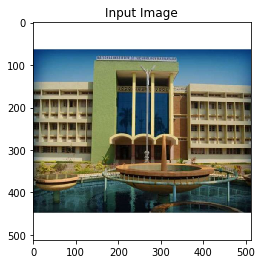

In [0]:
input_img=content_img.clone()
plt.figure()
imshow(input_img,title="Input Image")

In [0]:
def get_input_optimizer(input_img):
  #i/p parameter requring grad, optimizer to min the style and content losses
  optimizer=optim.LBFGS([input_img.requires_grad_()])
  return optimizer

In [0]:
def run_style_transfer(cnn,normalization_mean, normalization_std, content_img, style_img, input_img, num_steps=300, style_weight=1000000, content_weight=1):
  print("building style tranfer model...")
  model,style_losses, content_losses=get_style_model_and_losses(cnn, normalization_mean, normalization_std, style_img, content_img)
  optimizer=get_input_optimizer(input_img)
  
  print("Optimizing")
  
  run=[0]
  while run[0]<=num_steps:
    
    def closure():
      
      input_img.data.clamp_(0,1)
      
      optimizer.zero_grad()
      model(input_img)
      style_score=0
      content_score=0
      
      for s1 in style_losses:
        style_score+=s1.loss
      for c1 in content_losses:
        content_score+=c1.loss
      
      style_score*=style_weight
      content_score*=content_weight
      
      loss=style_score+content_score
      loss.backward()
      
      run[0]+=1
      if run[0]%50==0:
        
        print("run{}".format(run))
        print("Style Loss: {:4f} Content Loss: {:4f}".format(
            style_score.item(),content_score.item()))
        print()
      
      return style_score+content_score
    optimizer.step(closure)
    
  input_img.data.clamp_(0,1)
    
  return input_img
        
        
        
        

In [0]:
output=run_style_transfer(cnn,cnn_normalization_mean, 
                          cnn_normalization_std,content_img,
                          style_img,input_img)

building style tranfer model...
Optimizing


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.


run[50]
Style Loss: 123.666107 Content Loss: 39.956306

run[100]
Style Loss: 35.929806 Content Loss: 38.214966

run[150]
Style Loss: 17.919424 Content Loss: 35.854023

run[200]
Style Loss: 10.660140 Content Loss: 33.346149

run[250]
Style Loss: 7.440701 Content Loss: 31.233868

run[300]
Style Loss: 5.618549 Content Loss: 29.636860



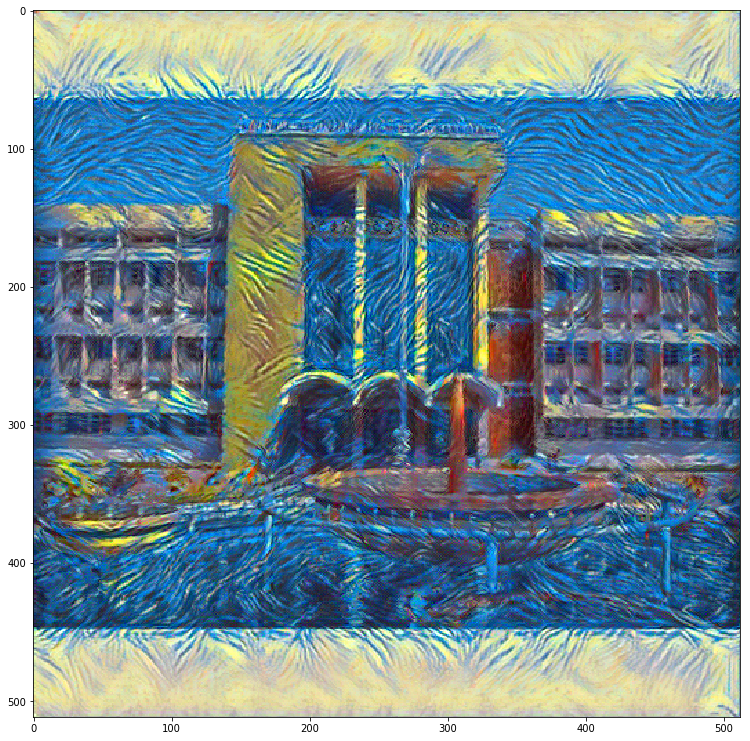

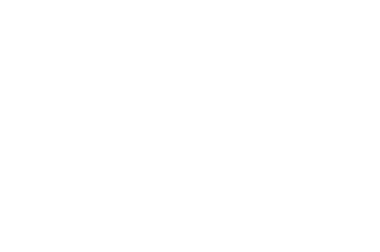

In [0]:
plt.figure(figsize=(13,13))
imshow(output)
plt.axis('off')
plt.ioff()
plt.show()